# Particle Filter with Multivariate Normal Approximation 

**Jonathan Ramkissoon, Martin Lysy**  
**University of Waterloo** 

---

## Introduction

Parameter inference for stochastic differential equations is challenging due to intractable likelihood functions that integrate over the entire latent space. Particle filters offer a principled solution by providing a consistent estimate of SDE log-likelihood. However, the multinomial resampling step traditionally used in particle filters is not smoothly differentiable with respect to SDE parameters, which can be problematic in many likelihood-based inference methods. In this work we propose a smoothly differentiable particle filter by replacing the resampling step with a multi- variate Normal approximation and utilizing the reparameterization trick. This enables a host of gradient based methods for parameter inference. This notebook explains the Multivariate Normal approximation within the particle filter and it's effect on parameter inference for stochastic differential equations. 


## Stochastic Differential Equations as State-Space Models

Let $\XX(t) = (X_1(t), \ldots, X_d(t))$ denote a $d$-dimensional process satisfying the stochastic differential equation (SDE)

$$
\ud \XX(t) = \dr_{\tth}(\XX(t)) \ud t + \df_{\tth}(\XX(t))^{1/2} \ud \BB(t),
$$

where $\dr_{\tth}(\XX)$ is a $d$-dimensional drift function and $\df_{\tth}(\XX)$ is a $d \times d$ positive-definite diffusion matrix.  We assume that $\XX(t)$ is measured with error at times $t_n = n \dt$ such that the observed data is $\YY_{0:N} = (\YY_0, \ldots, \YY_N)$ with

$$
\YY_n \ind g(\YY_n \mid \XX_n, \tth),
$$

where $\XX_n = \XX(t_n)$.  

Assume that the initial value of the SDE at time $t_0 = 0$ has the prior distribution $\XX_0 \sim \pi(\XX_0 \mid \tth)$. Then the likelihood function is given by

$$
\mathcal L(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX_n, \tth) \cdot \prod_{n=1}^N p(\XX_n \mid \XX_{n-1}, \tth)\right] \ud \XX_{0:N}.
$$

However, this expression requires the SDE transition density $p(\XX_n \mid \XX_{n-1}, \tth)$, which is rarely available in closed form.  Instead, the likelihood function is approximated by the so-called Euler (or Euler-Maruyama) discretization method.  Namely, for $m \ge 1$ let $\XX\up m_n$ denote the value of the SDE at time $t = n \dt/m$, such that $\XX\up m_{mn} = \XX_n = \XX(t_n)$.  As $\dt_m = \dt/m \to 0$, the normal approximation

$$
\begin{aligned}
\XX\up m_n & \sim \N( \XX\up m_{n-1} + \dr_{\tth}(\XX\up m_{n-1}) \dt_m, \df_{\tth}(\XX\up m_{n-1}) \dt_m) \\
\iff \XX\up m_n & \sim \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)
\end{aligned}
$$

becomes increasingly accurate.  Thus the Euler approximation of order $m$ (or resolution $m$) to the likelihood function is

$$
\Lhat_m(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX\up m_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX\up m_{nm}, \tth) \cdot \prod_{n=1}^{Nm} \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)\right] \ud \XX\up m_{0:Nm},
$$

and we have $\Lhat_m(\tth \mid \YY_{0:N}) \to \mathcal L(\tth \mid \YY_{0:N})$ as $m \to \infty$.

## Log-Likelihood Estimation with Particle Filters

In general, a particle filter is initialized with a point cloud simulated from $\XX^* \sim p(X_0)$. At each timestep it is updated according to the transition density $p(X_t \mid X_{t-1}, \theta)$ and re-weighted according to $p(y_t \mid \XX^*_t, \theta)$. The resulting point cloud after this scheme are samples from the density $p(\XX_{t+1} \mid y_{t+1}, \theta)$. 

Bootstrap particle filters perform a Multinomial resampling step after re-weighting to avoid sample impoverishment. After running this scheme for every timestep, we can sum the log-weights to get an estimate of the log-likelihood. 

In the context of gradient based inference methods, such as maximum likelihood, the multinomial resampling results in non-smooth estimates of the log-likelihood. To ensure a smooth estimate of the log-likelihood, the multinomial resampling step can be replaced with a Multivariate Normal distribution. 

Here, we approximate the particle distribution, **$p(X_{t+1} \mid y_t, X_t)$** with a multivariate Normal. That is, at timestep $t+1$, we have:

- $N$ particles from timestep $t$: $\XX^*_t$
- Corresponding weights from evaluating $p(y_t \mid \XX^*_t)$

Then the particle distribution for timestep $t+1$ uses the weighted mean and weigthed covariance matrix of particles at timestep $t$ as parameters for the MVN.


## MVN Approximation in `pfjax`

`pfjax` is set up to accomodate for different resampling methods, and the MVN approximation is no exception. An example of this is shown below: 

- [x] SDE approximation to state-space model 
- [x] Particle filter estimation the log-likelihood
- [x] Multinomial approximation of particle distribution 
- [ ] Explanation of the model
    - [ ] **Check particle distribution**
- [ ] Explanation of the model in pfjax
- [ ] Comparison of MVN filter and bootstrap filter
    - [ ] Compare mode finding (i.e. stoch opt)
    - [ ] Stability of optimization 

# Lotka-Volterra Example

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
import optax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

In [130]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1 
tau_l = 0.1 

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/2), theta + (theta/2))))

dt = 0.1
n_res = 1 
n_obs = 100
lotvol_model = pf.LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)

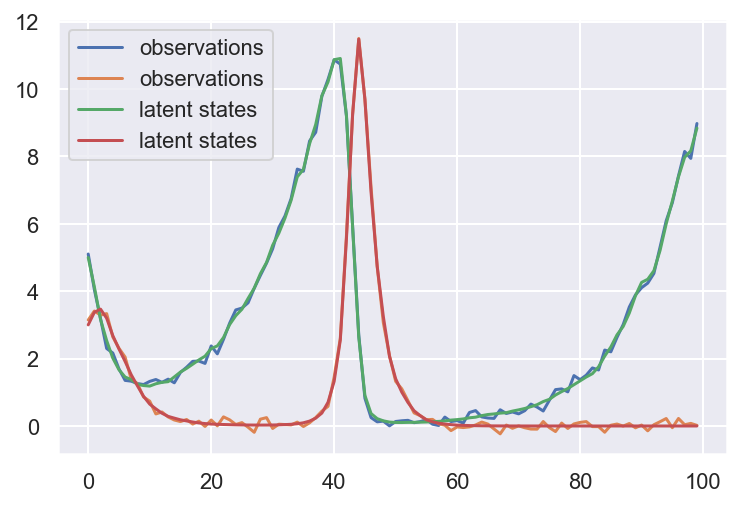

In [3]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

## Log-Likelihood Projection Plots

- [ ] Explain what this is: Bootstrap and MVN filter estimates of the log-likelihood for each parameter around the true value. 

In [4]:
# log-likelihood for Lotvol model with MVN resamplings
@jax.jit
def lotvol_pf_mvn_loglik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, 
                           y_meas=y_meas, 
                           n_particles=n_particles, key=key,
                           particle_sampler = pf.particle_resample_mvn)
    return pf.particle_loglik(temp['logw'])

# log-likelihood for Lotvol model with Multinomial resampling
@jax.jit
def lotvol_pf_loglik(theta):
    temp = pf.particle_filter(theta=theta, 
                           model=lotvol_model, y_meas=y_meas,
                           n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])

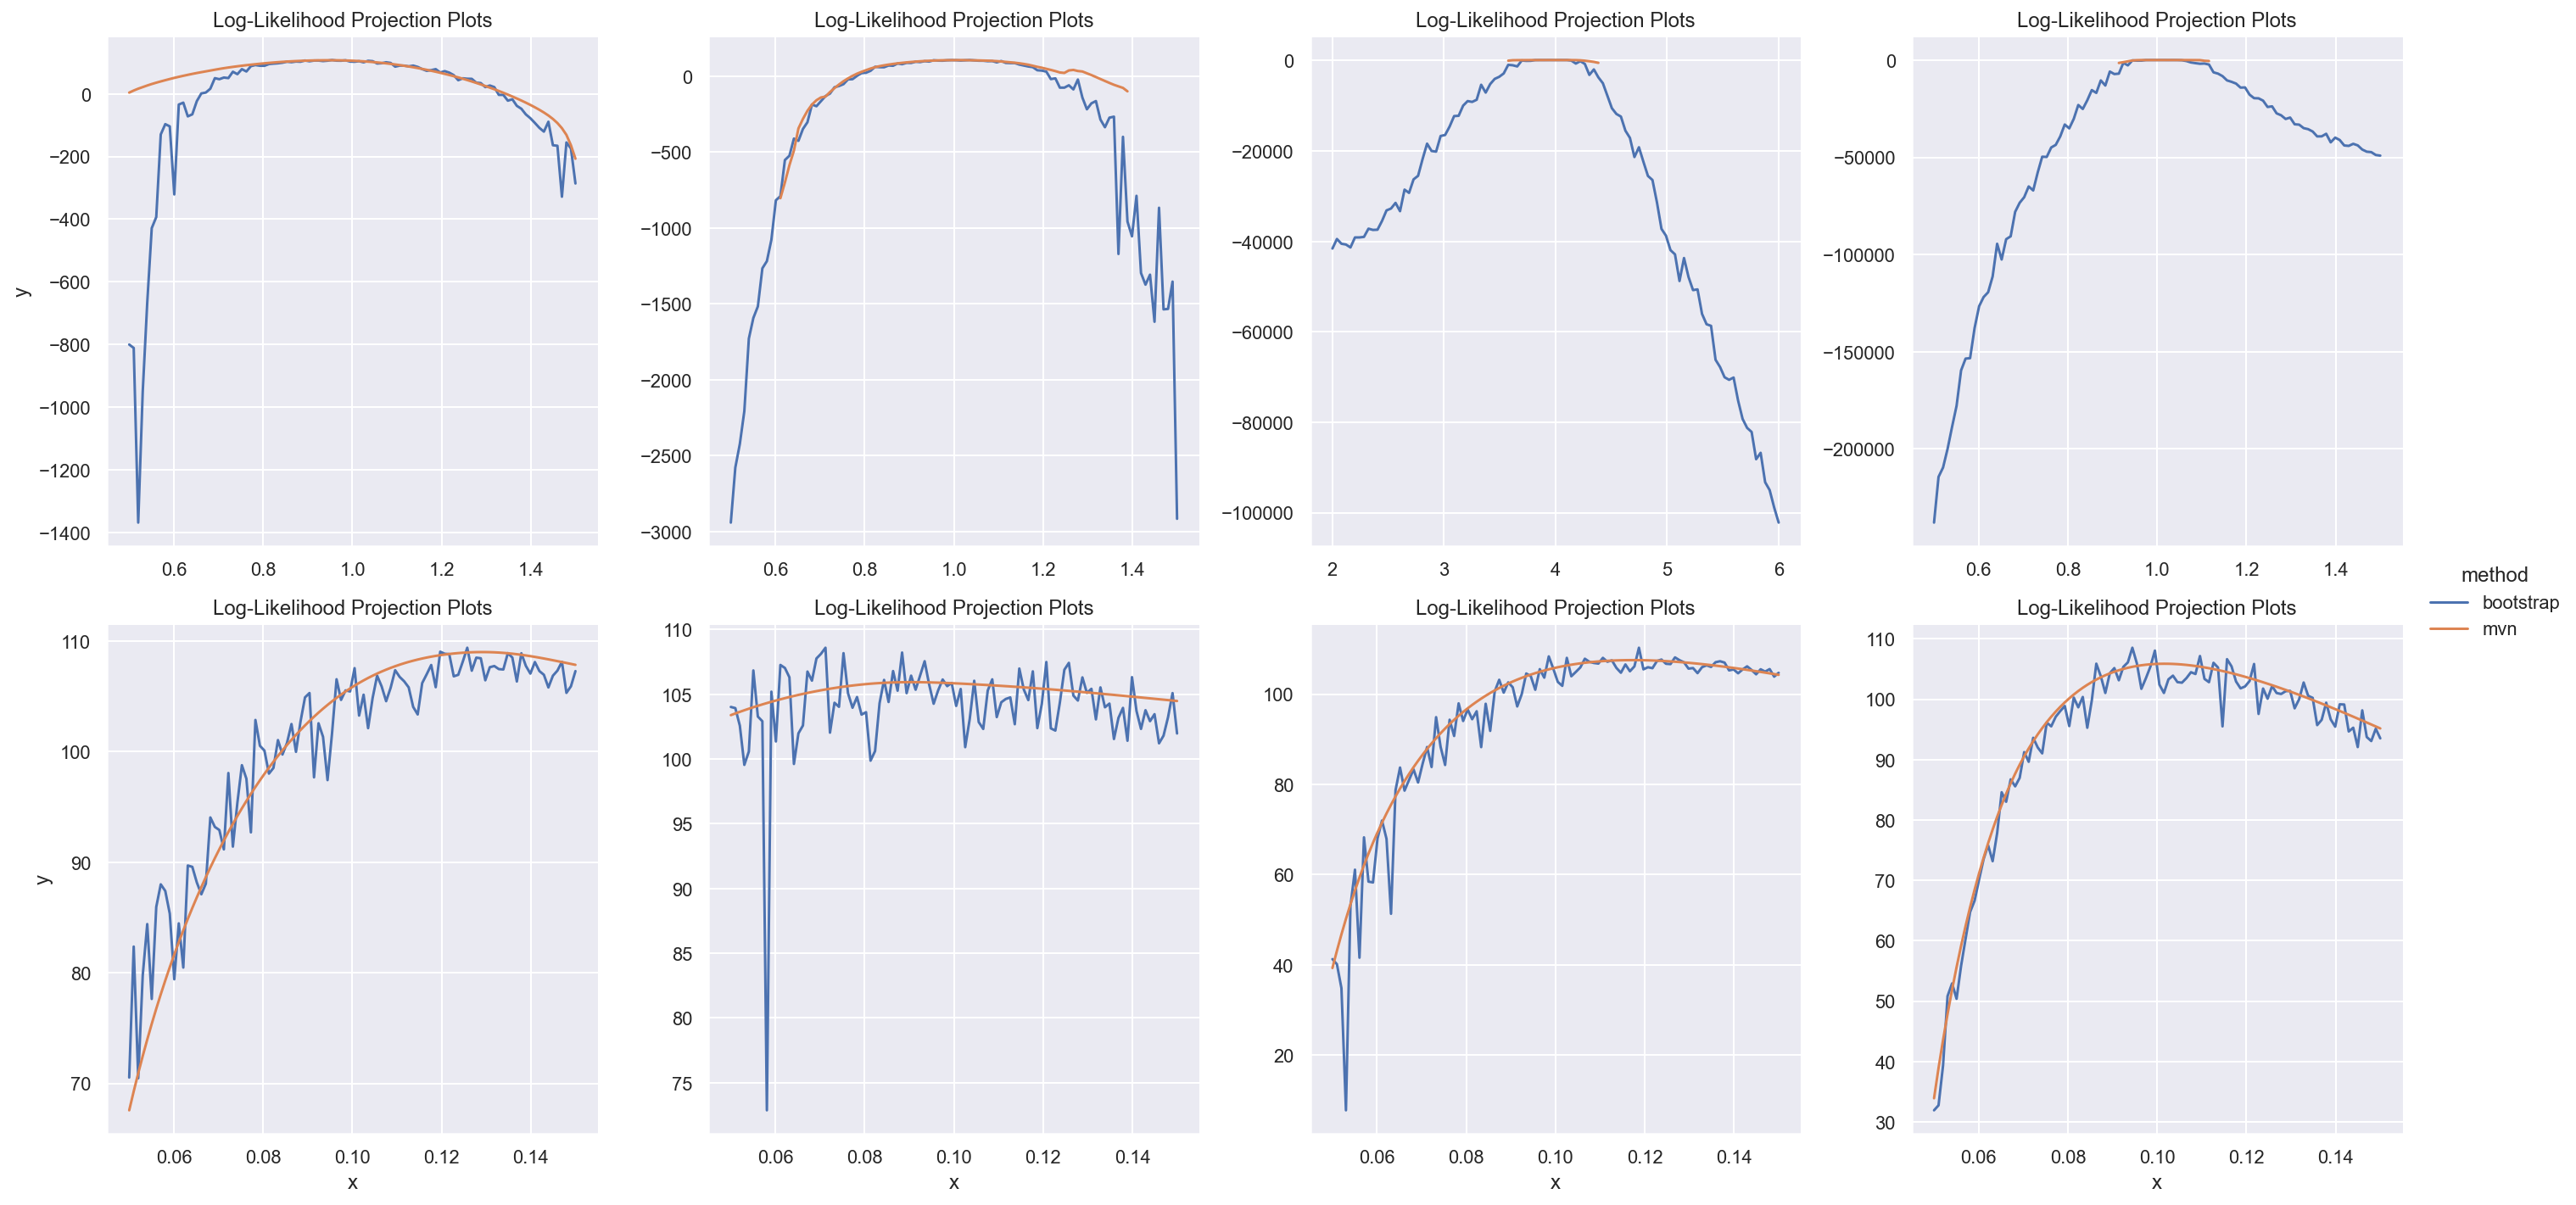

In [161]:
n_particles = 500

plot_mvn = pf.proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x), 
                        theta = theta, theta_lims = theta_lims, 
                        theta_names = theta_names)

plot_bootstrap = pf.proj_data(fun = lambda x: lotvol_pf_loglik(x),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_bootstrap["method"] = "bootstrap"
df = pd.concat([plot_bootstrap, plot_mvn]).reset_index(drop=True)

sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

## Full-Bayesian Inference

- [ ] Explain what we are doing here: Deterministic optimization of parameters. Use Fisher information matrix as the variance estimate.

In [106]:
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        grad_fun: The function with which to take the gradients with respect to.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        model: The model class which has the predefined methods to run the forward pass.
        learning_rate: The learning rate for the stochastic optimization method.
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        theta = update_fn(theta, subkey, opt_state)
    return theta


def stoch_opt(model, theta, grad_fun, y_meas, n_particles=100, 
              n_iter=10, learning_rate=0.01, key=1, mask=None):
    """
    Args:
        model: The model class for which all of the functions are defined.
        theta: A jnp.array that represents the initial values of the parameters.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        n_iter: The number of n_iter to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        theta: The final value of the parameters.
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, n_iter)
#     print(len(keys))
    for subkey in keys:
        theta = update_fn(theta, subkey, opt_state)
    return theta 

In [7]:
init_params = jnp.array([1.,0.9, 3.8, 1., 0.1, 0.1, 0.1, 0.1])
print("True params: ", theta)

mvn_params = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = 1e-2,
    n_iter = 50,
    n_particles = 100,
    mask=np.ones(len(init_params))
)
mvn_params

True params:  [1.  1.  4.  1.  0.1 0.1 0.1 0.1]


DeviceArray([0.92000055, 0.9799994 , 3.8999999 , 1.        , 0.13999973,
             0.10000001, 0.11999987, 0.1       ], dtype=float32)

In [8]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik_mvn))
hess = hessian_fn(
    mvn_params,
    key,
    n_particles=100,
    y_meas=y_meas,
    model=lotvol_model)
print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

Is positive definite?:  True


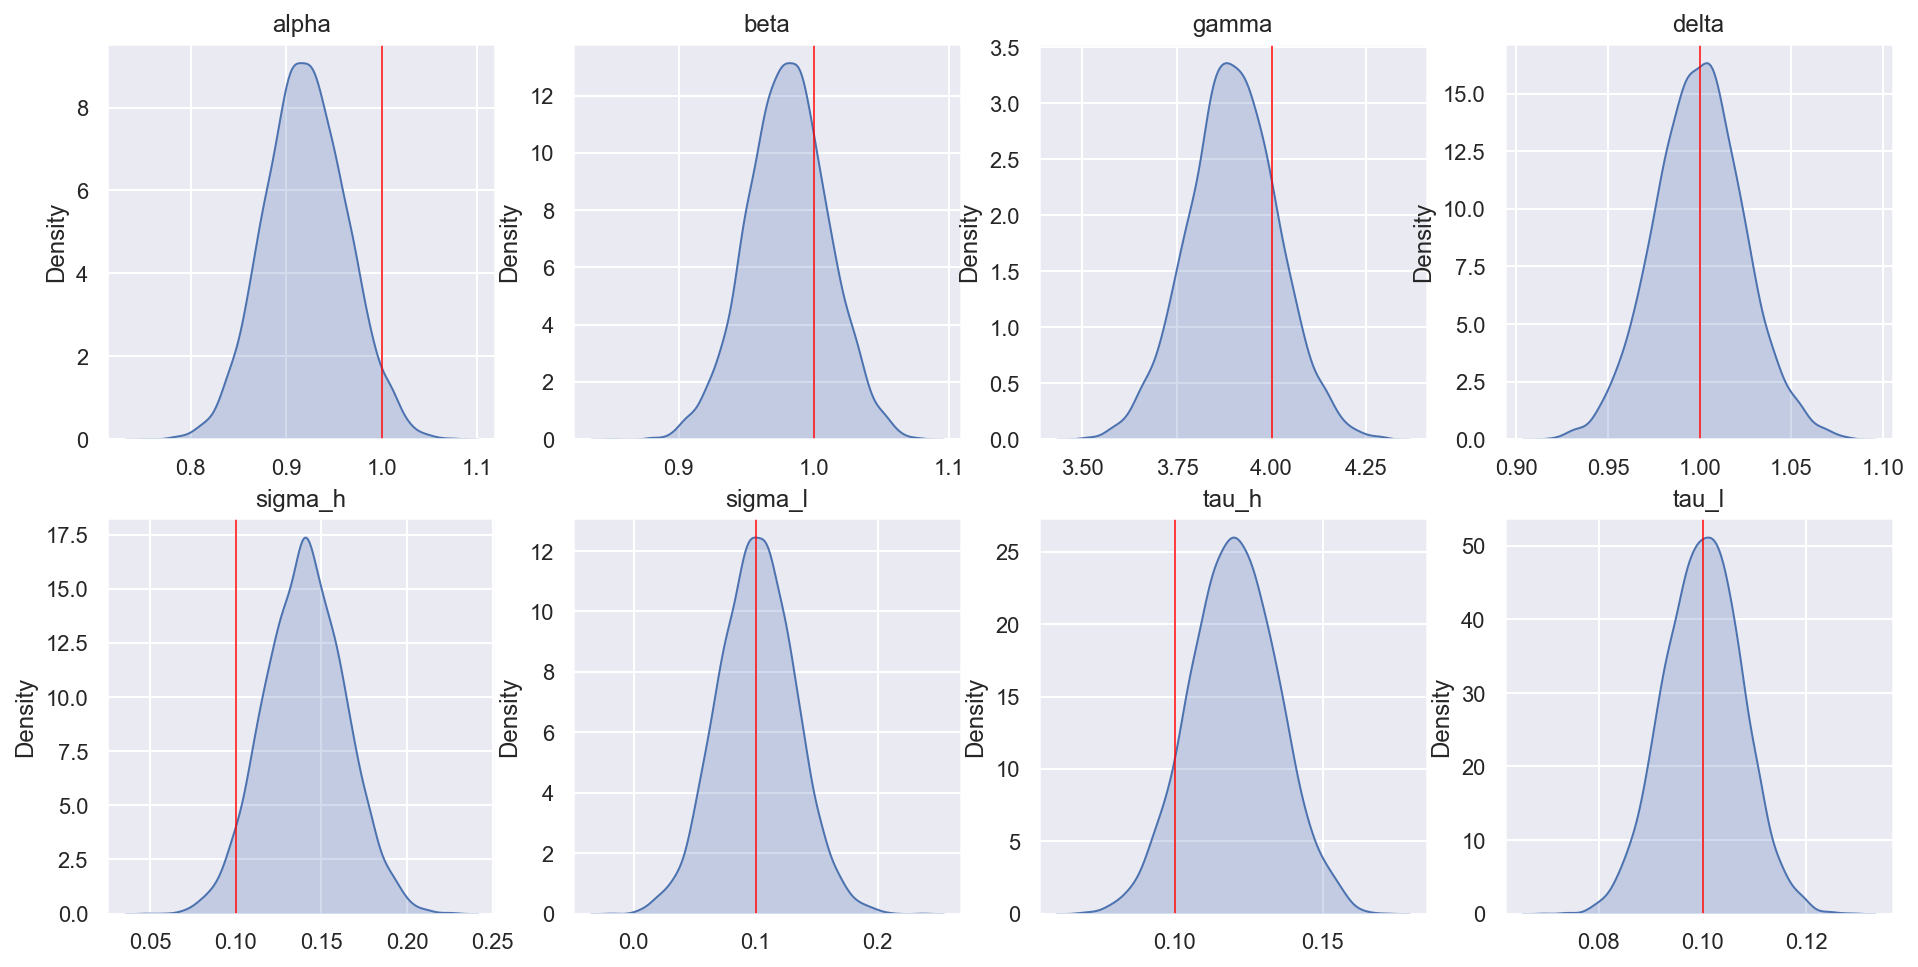

In [10]:
# Once hessian is positive definite, we can find the posterior variance. Otherwise continue optimization 
# posterior variance is the inverse negative hessian of the log-likelihood (Fisher Information)
var = jnp.linalg.inv(hess)

mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

# Comparison with Multinomial Resampling

In this section, we make comparisons between the bootstrap particle filter with stochastic optimization and the MVN particle filter using deterministic optimization. In particular, we are interested in the accuracy and stability (variance) of the estimate. We are also interested in the number of particles needed to produce consistent estimates. 

## Experiment 1: Same Parameters

Using the same parameters for both filter, compare results

In [147]:
# Fix parameters and run both filters with these: 
n_particles = 100
n_iter = 100
learning_rate = 1e-2

init_params = jnp.array([1.,0.9, 3.8, 1., 0.1, 0.1, 0.1, 0.1])
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [1.  1.  4.  1.  0.1 0.1 0.1 0.1]
Initial params:  [1.  0.9 3.8 1.  0.1 0.1 0.1 0.1]


### Point Estimates

- Increasing iterations for bootstrap filter doesn't guarantee convergence. This is likely due to the non-smoothness of the log-likelihood

In [148]:
mvn_params = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

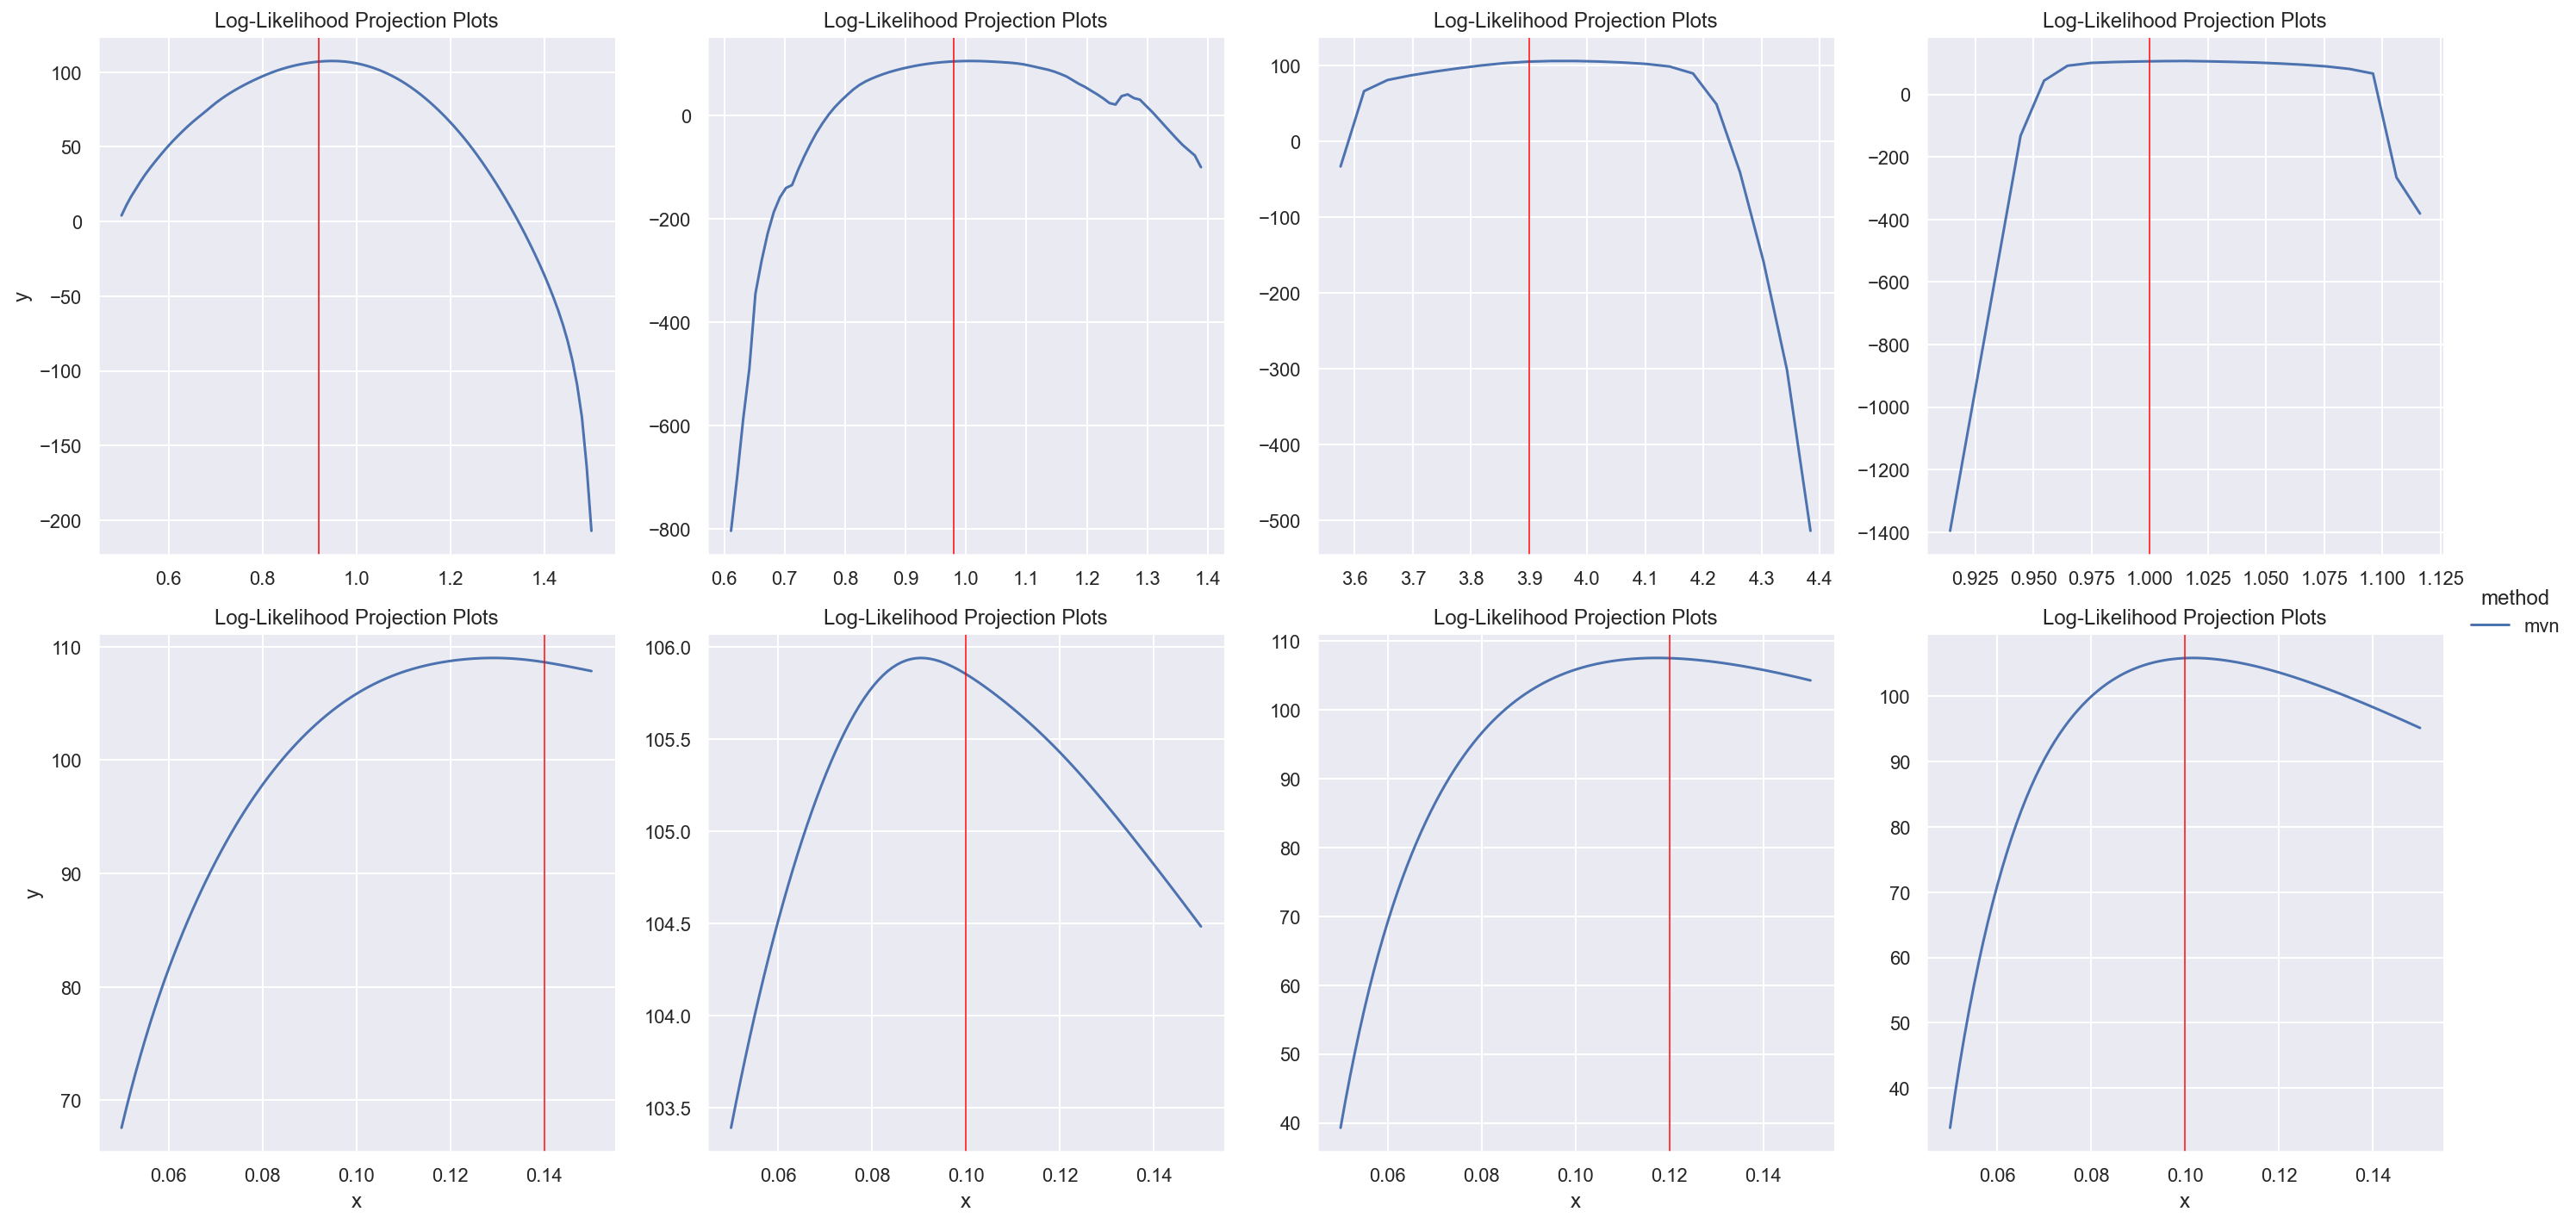

In [149]:
plot_mvn = pf.proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x), 
                    theta = theta, theta_lims = theta_lims, 
                    theta_names = theta_names)

plot_mvn["method"] = "mvn"

grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

In [143]:
multinom_params = stoch_opt(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

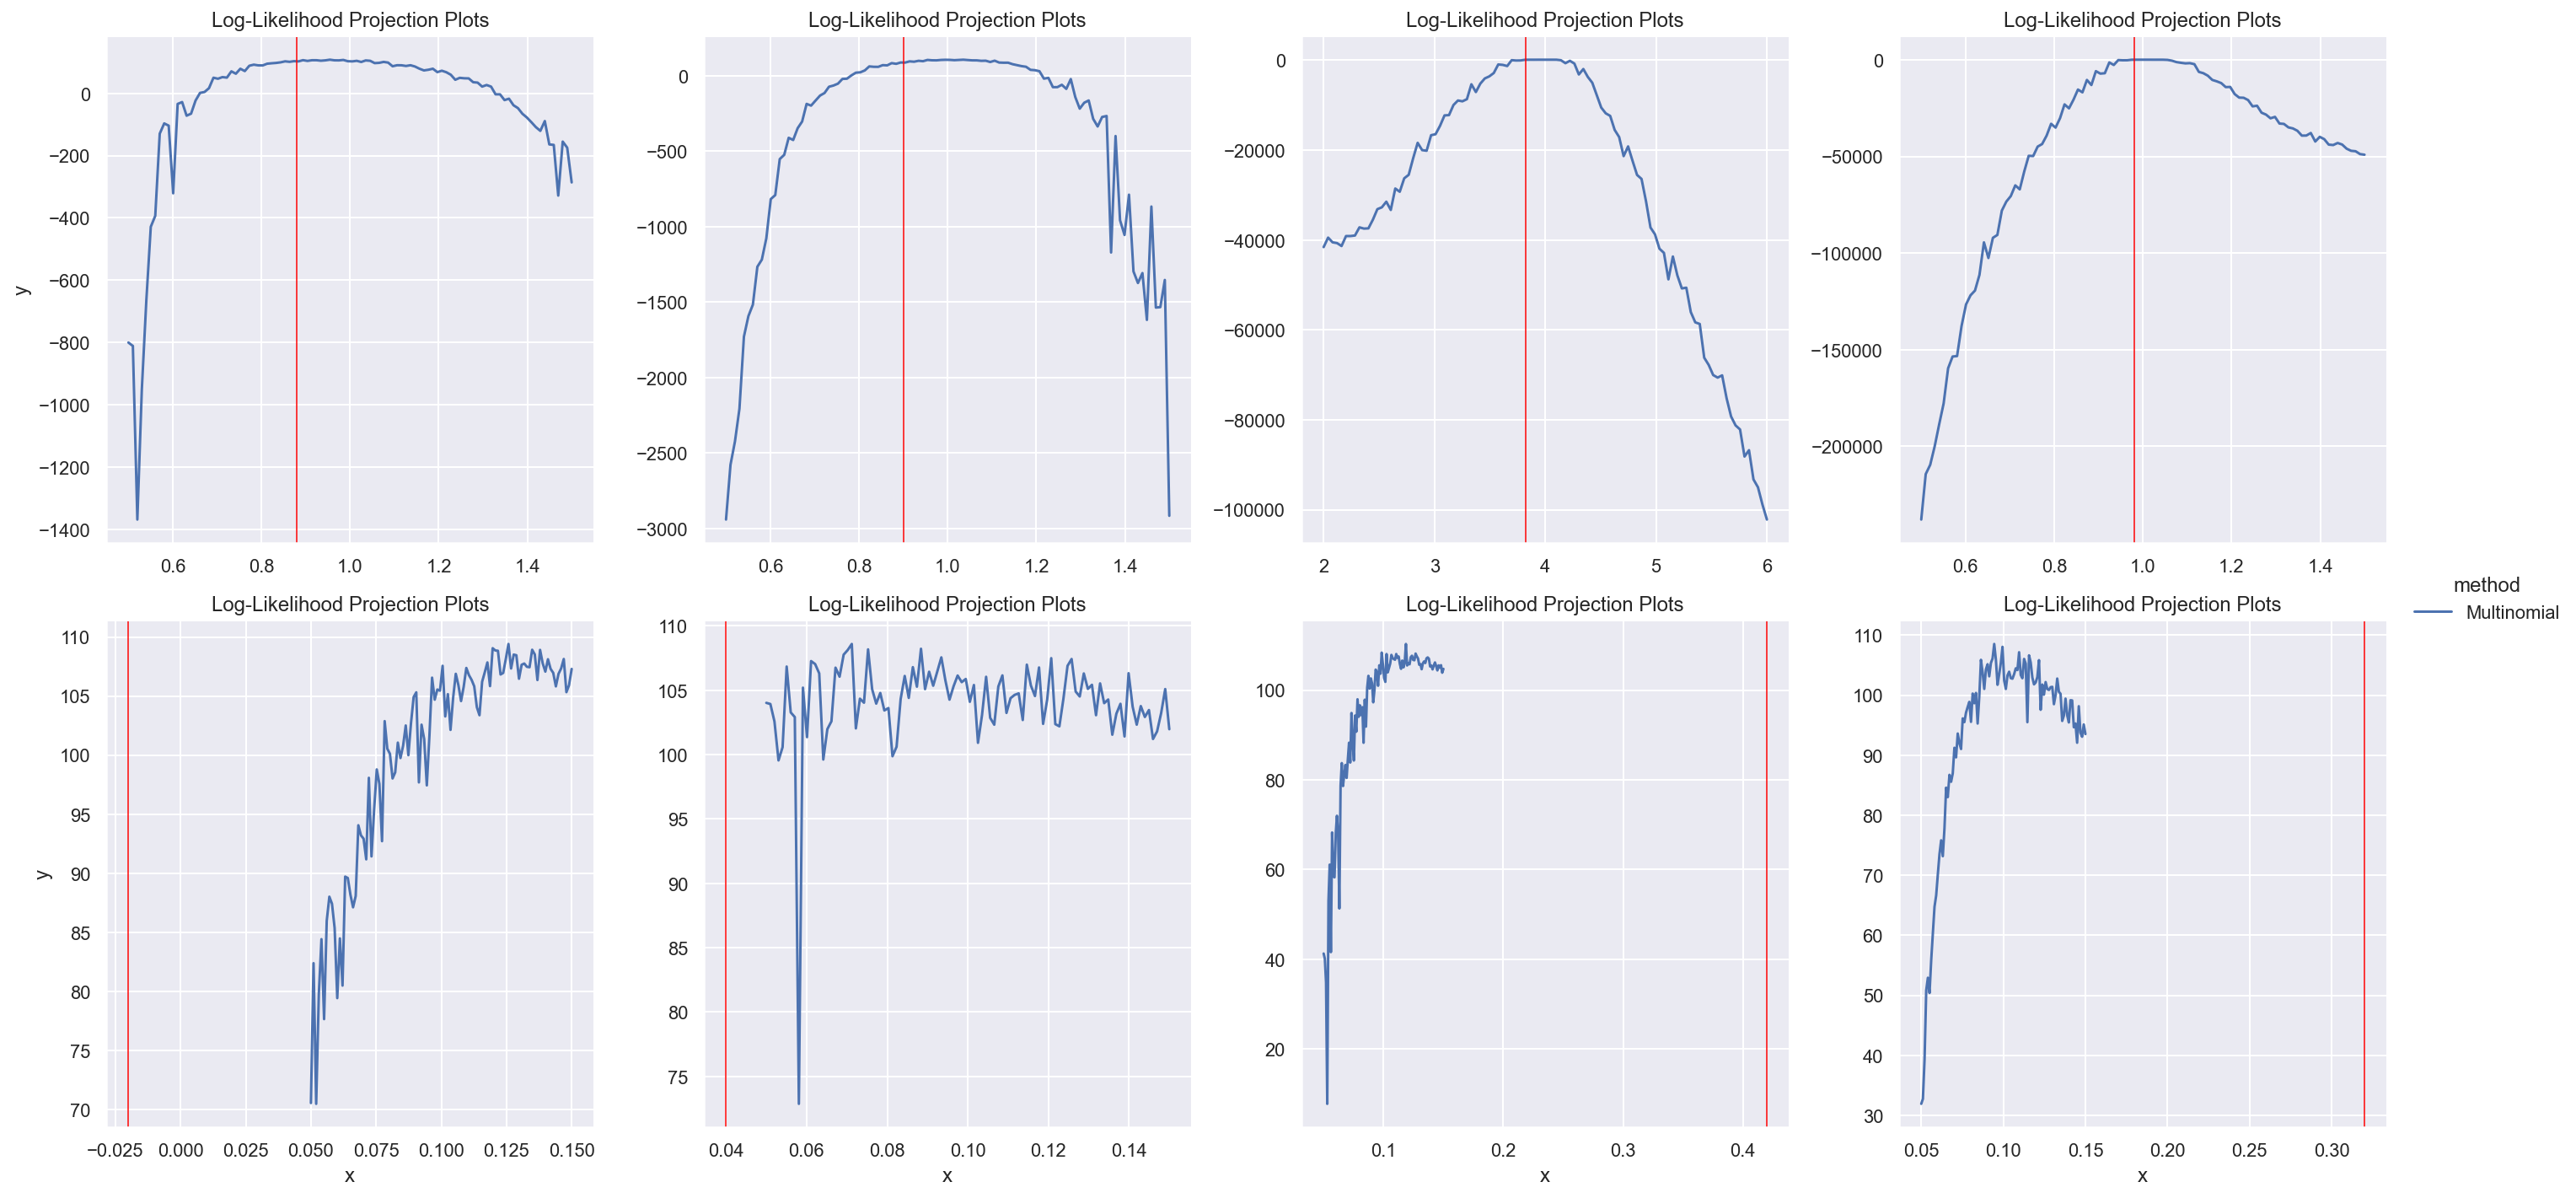

In [145]:
plot_multinom = pf.proj_data(fun = lambda x: lotvol_pf_loglik(x),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_multinom["method"] = "Multinomial"

grid = sns.relplot(
    data=plot_multinom, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(multinom_params[ind], color='red', lw = 0.75);

In [146]:
print("MVN filter MSE for {} particles, {} iterations: {}".format(n_particles, n_iter, sum((mvn_params - theta)**2)))
print("Bootstrap filter MSE for {} particles, {} iterations: {}".format(n_particles, n_iter, 
                                                                  sum((multinom_params - theta)**2)))

MVN filter MSE for 250 particles, 100 iterations: 0.018799936282448526
Bootstrap filter MSE for 250 particles, 100 iterations: 0.22599751388770528


### Convergence

In [137]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
multinom_hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik))
multinom_hess = multinom_hessian_fn(
    multinom_params,
    key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)
print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(multinom_hess) >= 0))

Is positive definite?:  False


In [78]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
mvn_hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik_mvn))
mvn_hess = mvn_hessian_fn(
    mvn_params,
    key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)
print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(mvn_hess) >= 0))

Is positive definite?:  True


### Variance Estimates

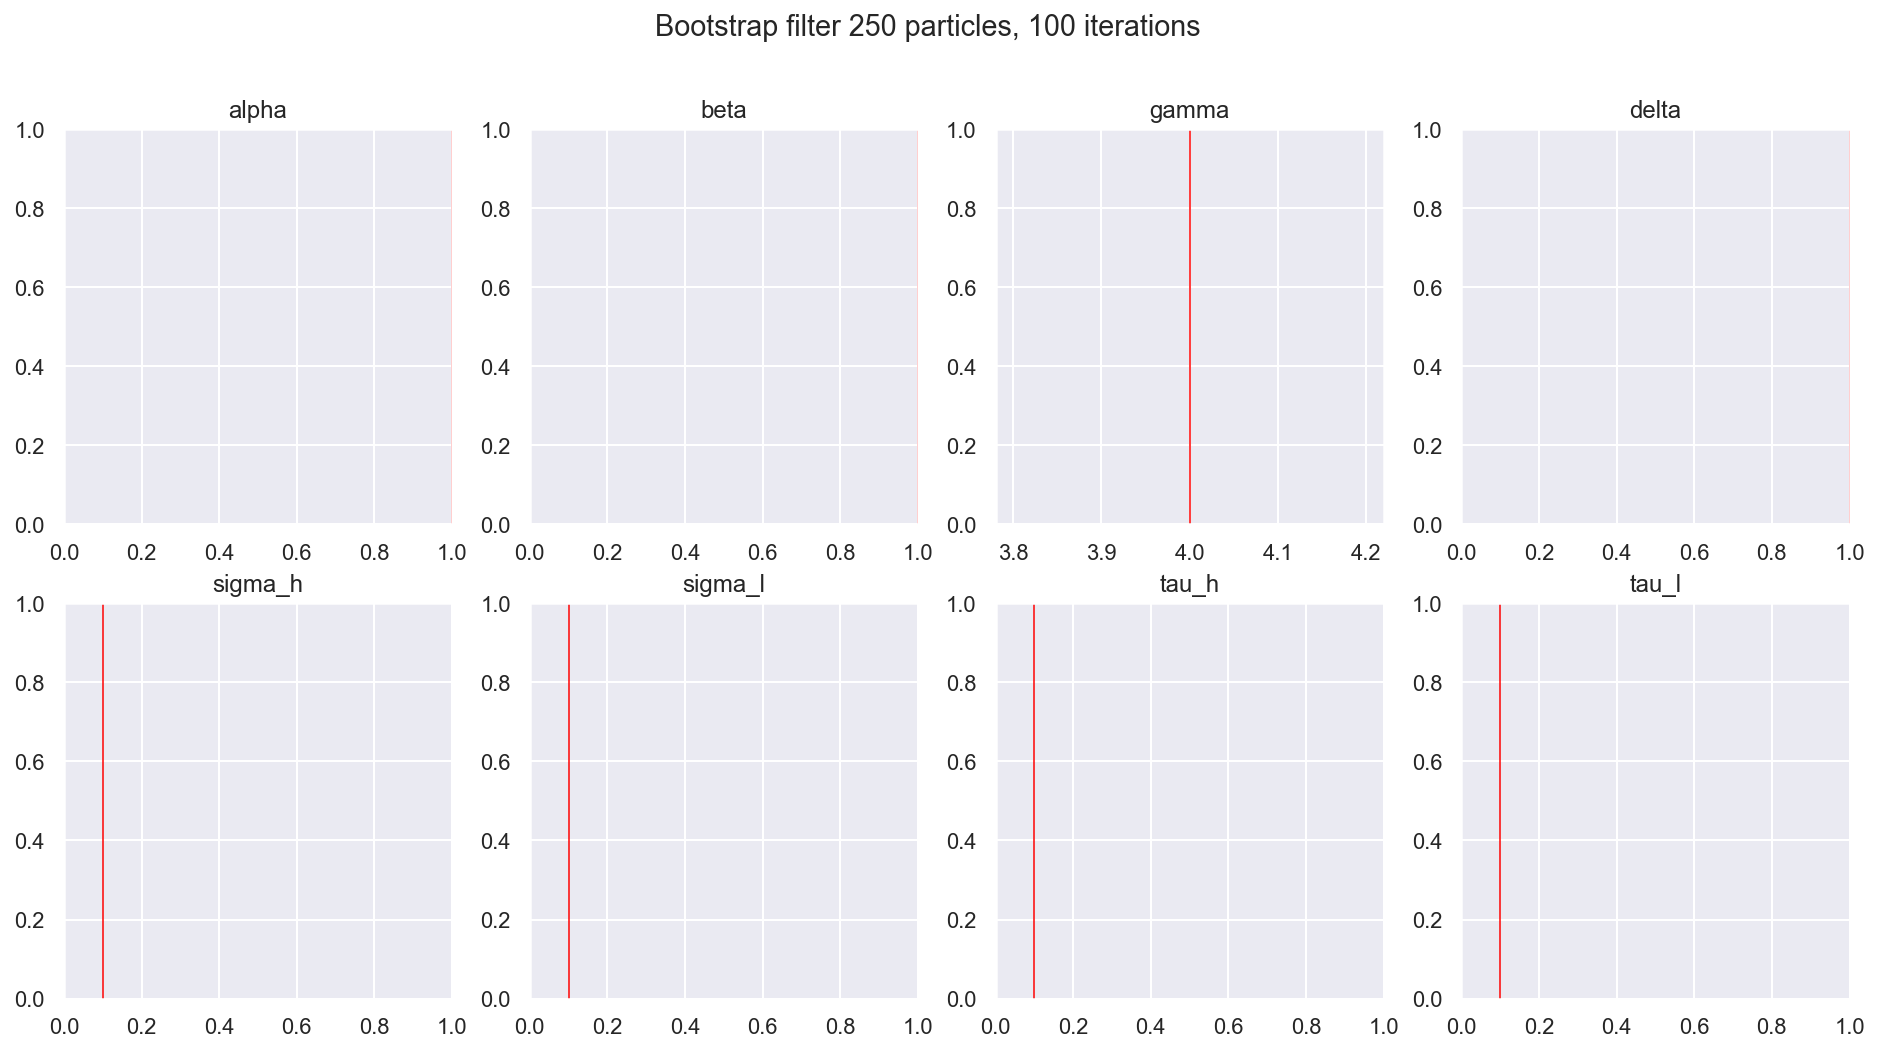

In [138]:
# Once hessian is positive definite, we can find the posterior variance. Otherwise continue optimization 
# posterior variance is the inverse negative hessian of the log-likelihood (Fisher Information)
multinom_var = jnp.linalg.inv(multinom_hess) + np.diag([1e-3]*len(multinom_params))
mn_mle_samples = random.multivariate_normal(
    key=key, 
    mean=multinom_params, 
    cov=multinom_var, 
    shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Multinomial Resampling {} particles, {} iterations".format(n_particles, n_iter)) 
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mn_mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

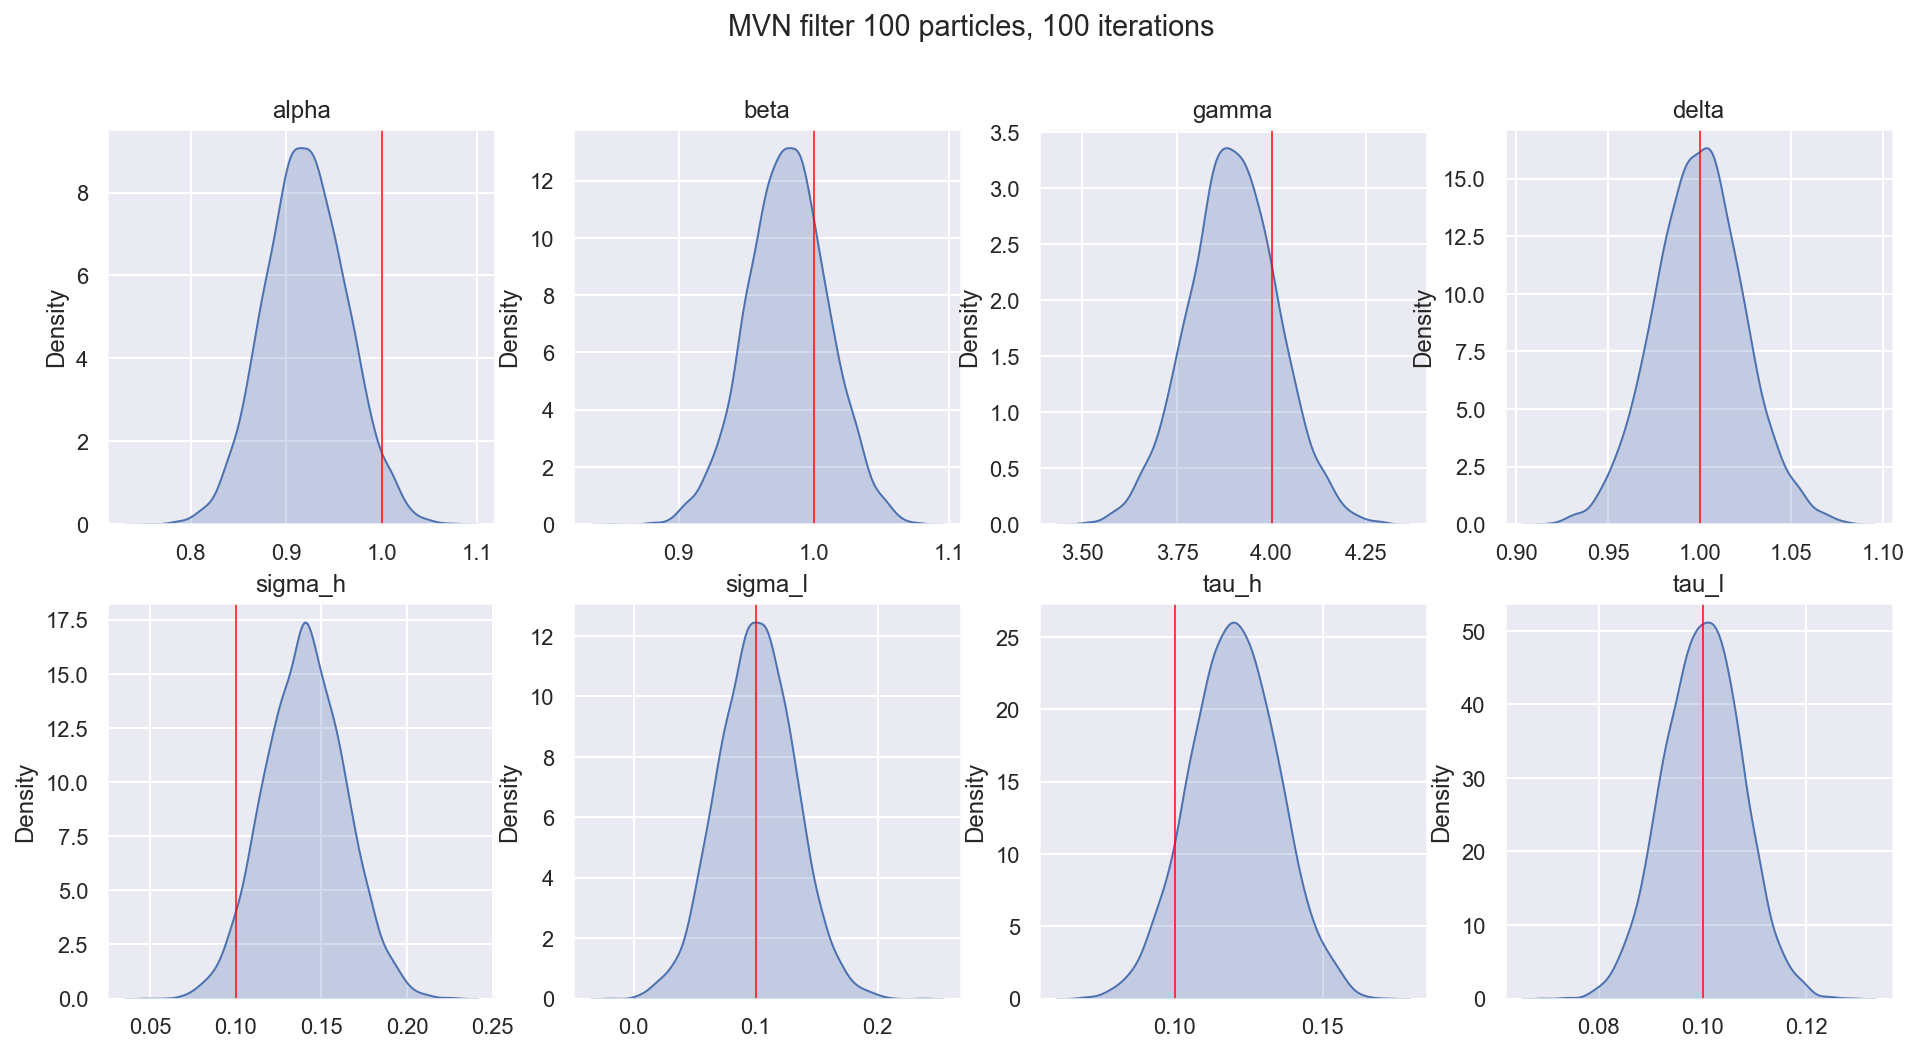

In [84]:
# Once hessian is positive definite, we can find the posterior variance. Otherwise continue optimization 
# posterior variance is the inverse negative hessian of the log-likelihood (Fisher Information)
mvn_var = jnp.linalg.inv(mvn_hess)
mvn_mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=mvn_var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("MVN Resampling {} particles, {} iterations".format(n_particles, n_iter)) 
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mvn_mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

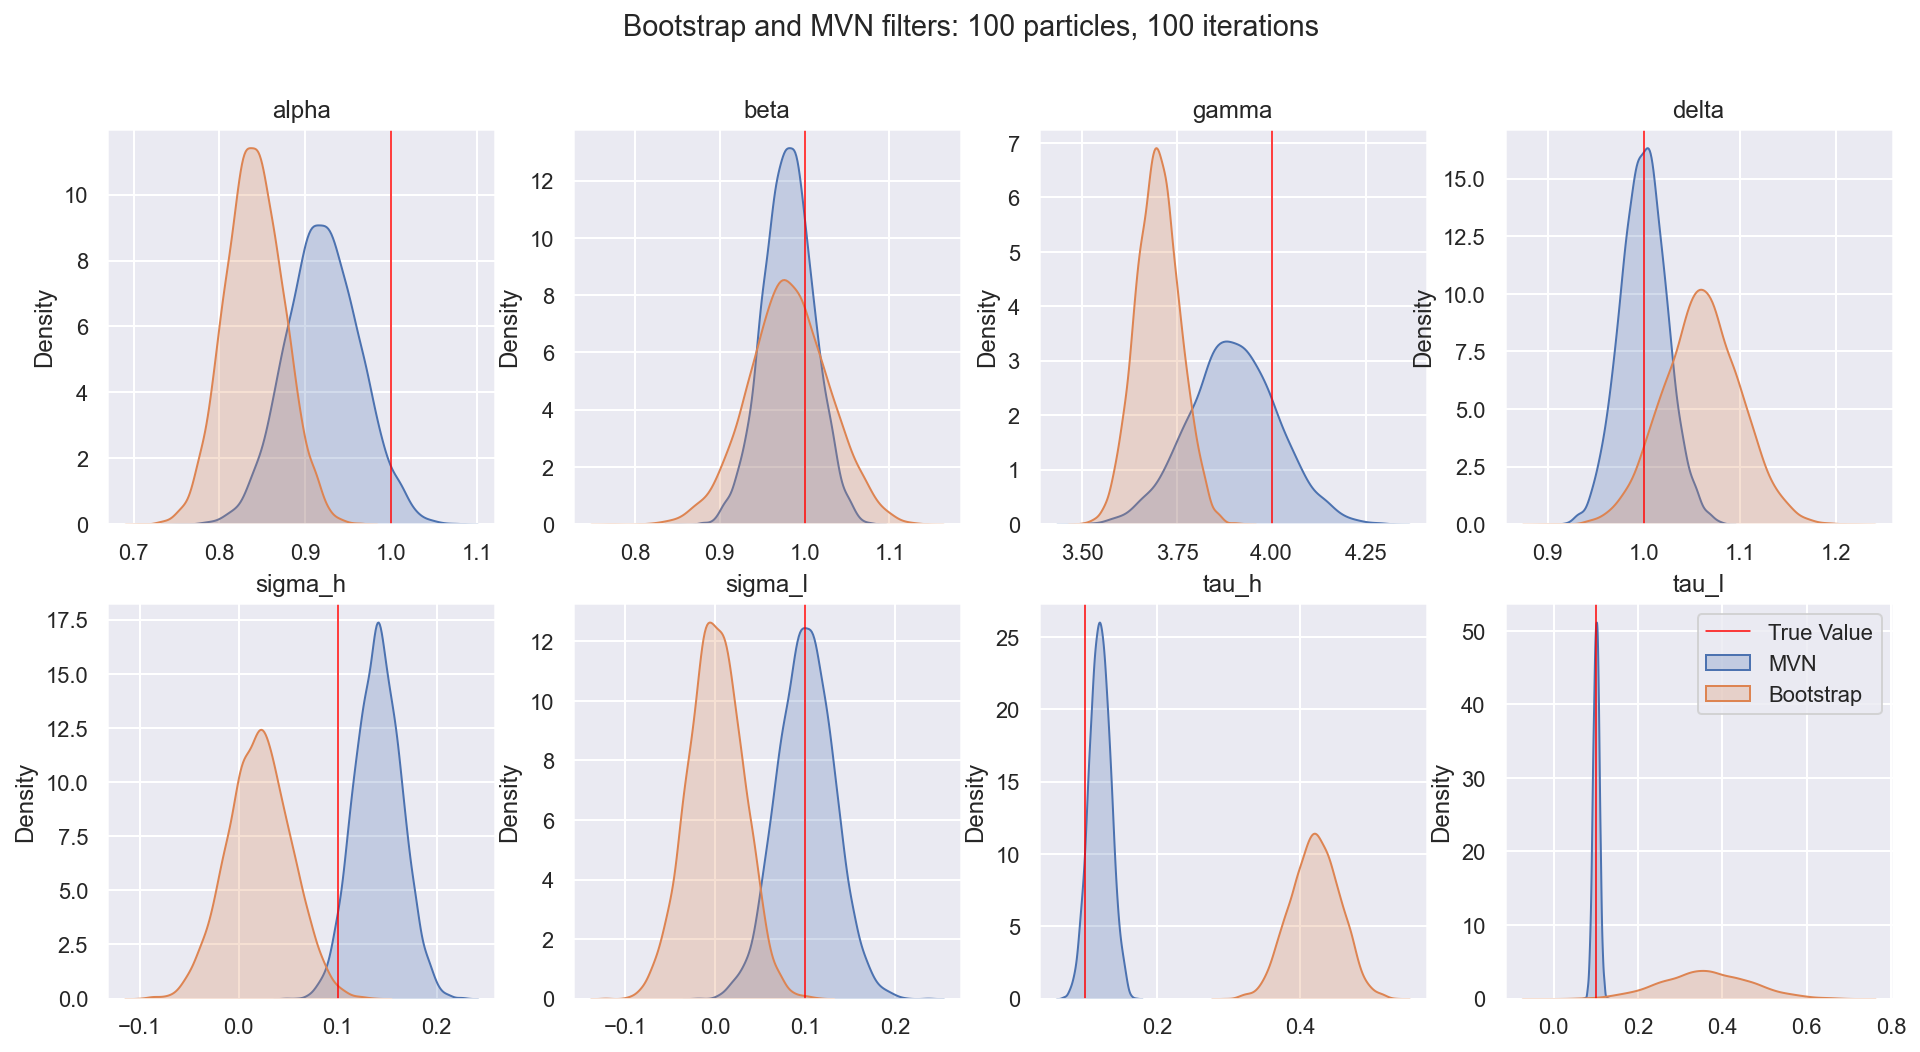

In [96]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Multinomial and MVN Resampling: {} particles, {} iterations".format(n_particles, n_iter)) 
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mvn_mle_samples[:, ind], ax = _ax, 
                label = "MVN",
                shade = True).set_title(theta_names[ind])
    sns.kdeplot(mn_mle_samples[:, ind], ax = _ax, 
                label = "Multinomial",
                shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75, label = "True Value")
    
plt.legend()
plt.show();

## Experiment 2: Best Parameters

Using poor initial values, choose the best parameters for both filters and compare results. 

In [97]:
init_params2 = jnp.array([1.,0.9, 3.8, 1., 0.1, 0.1, 0.1, 0.1])
print("True params:    ", theta)
print("Initial params: ", init_params2)

True params:     [1.  1.  4.  1.  0.1 0.1 0.1 0.1]
Initial params:  [1.  0.9 3.8 1.  0.1 0.1 0.1 0.1]


### Point Estimates - Best Params

In [98]:
mvn_learning_rate = 1e-3
mvn_n_iter = 200
mvn_n_particles = 200

mvn_params2 = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params2,
    learning_rate = mvn_learning_rate,
    n_iter = mvn_n_iter,
    n_particles = mvn_n_particles,
    mask=np.ones(len(init_params))
)

In [122]:
bs_particles = 1000
bs_learning_rate = 1e-2
bs_n_iter = 500

bootstrap_params2 = stoch_opt(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik,
    y_meas = y_meas,
    theta = init_params2,
    learning_rate = bs_learning_rate,
    n_iter = bs_n_iter,
    n_particles = bs_particles,
    mask=np.ones(len(init_params))
)

bootstrap_params2

DeviceArray([ 0.9000007 ,  0.8800002 ,  3.76      ,  0.9600003 ,
              0.02000053, -0.11999853,  0.23999906,  0.15999961],            dtype=float32)

In [124]:
print("MVN filter MSE for {} particles, {} iterations: {}".format(mvn_n_particles, 
                                                                  mvn_n_iter, 
                                                                  sum((mvn_params2 - theta)**2)))
print("Bootstrap filter MSE for {} particles, {} iterations: {}".format(bs_particles, bs_n_iter, 
                                                                  sum((bootstrap_params2 - theta)**2)))

MVN filter MSE for 200 particles, 200 iterations: 0.0008400034553801561
Bootstrap filter MSE for 1000 particles, 500 iterations: 0.1615987626137212


## TODO

- Plot each posterior for bootstrap and MVN filters on the same plot. This way we can see the difference in variance. 
- Convert LotVol SDE to log scale. Use Mohan's branch
- How do the resampling methods for different resolution numbers?
- Create notebook of comparison for MVN VS Multinomial resampling methods. Assume research group only understand the two filters but don't know about the differences.
- Superimpose parameter estimates on projection plots
- Use Kanika's library for proj plots


- Can the point cloud be estimated by a Gaussian process? Will this be differentiable? Are there any advantages to using this over a MVN?